In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from sklearn.utils import shuffle

from keras.layers import Dense, Input, Dropout
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import argparse
import os
from utils import get_numpy_imgs, gen_labels, sampling, plot_results

Using TensorFlow backend.


In [2]:
# dataset
_figPath = 'images'
_modelPath = 'models'
_model = ''
os.makedirs(_figPath, exist_ok=True)
os.makedirs(_modelPath, exist_ok=True)
_imgPath = '../all-mias/mdb'
_labelsPath = '../all-mias/Info.txt'
_stepSize = 0.05
_img_size = 256

# network parameters
_input_shape = (_img_size, _img_size, 1)
_batch_size = 16
_kernel_size = 3
_filters = 16
_latent_dim = 10
_epochs = 500
_loss = "mse" #mse or ce

images = get_numpy_imgs(_imgPath, _img_size)
images = np.expand_dims(images, axis=3)
labels = gen_labels(_labelsPath)
images = images.astype('float32') / 255

size = images.shape[0]

X, y = shuffle(images, labels)

x_train = X[0:int(size*0.8)]
x_test = X[int(size*0.8):]
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

data = (x_test, y_test)

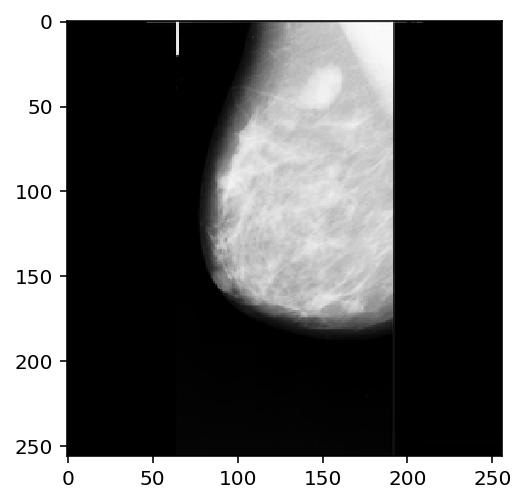

1


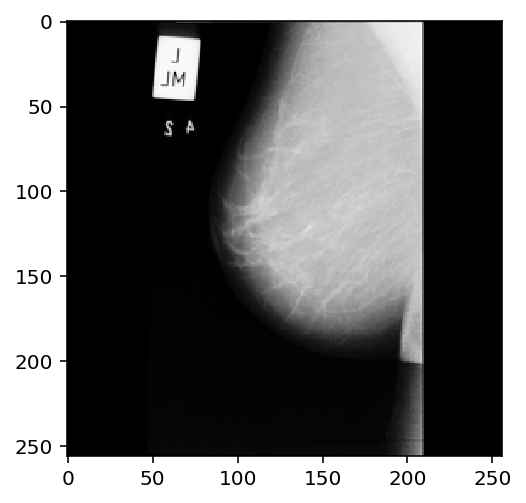

0


In [3]:
idx = 14
img = images[idx]
img.shape
plt.imshow(img[:,:,0], cmap='Greys_r')
plt.savefig(os.path.join(_figPath, "cancer.png"))
plt.show()
print(labels[idx])

idx = 10
img = images[idx]
img.shape
plt.imshow(img[:,:,0], cmap='Greys_r')
plt.savefig(os.path.join(_figPath, "healthy.png"))
plt.show()
print(labels[idx])

In [4]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=_input_shape, name='encoder_input')
x = inputs
for i in range(4):
    _filters *= 2
    x = Conv2D(filters=_filters,
               kernel_size=_kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    x = Dropout(0.5)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(_latent_dim*4, activation='relu')(x)
z_mean = Dense(_latent_dim, name='z_mean')(x)
z_log_var = Dense(_latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(_latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file=f'vae_{_latent_dim}_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(_latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(4):
    x = Conv2DTranspose(filters=_filters,
                        kernel_size=_kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    x = Dropout(0.5)(x)
    _filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=_kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file=f'vae_{_latent_dim}_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
models = (encoder, decoder)

# VAE loss = mse_loss or xent_loss + kl_loss
if _loss == "mse":
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

reconstruction_loss *= _img_size * _img_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae, to_file=f'vae_{_latent_dim}_{_loss}.png', show_shapes=True)          

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   18496       dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [5]:
if _model == '':
    vae.fit(x_train, epochs=_epochs, batch_size=_batch_size,validation_data=(x_test, None))
    vae.save_weights(os.path.join(_modelPath,f'vae_{_latent_dim}_{_loss}.h5'))
else:
    vae.load_weights(_model)

Train on 257 samples, validate on 65 samples
Epoch 1/500
257/257 [==============================] - 5s 20ms/step - loss: 8326.6652 - val_loss: 4948.3268
Epoch 2/500
257/257 [==============================] - 2s 6ms/step - loss: 4141.2705 - val_loss: 3626.1368
Epoch 3/500
257/257 [==============================] - 2s 6ms/step - loss: 3359.7214 - val_loss: 2940.7700
Epoch 4/500
257/257 [==============================] - 2s 6ms/step - loss: 2523.2997 - val_loss: 2461.8217
Epoch 5/500
257/257 [==============================] - 2s 6ms/step - loss: 2270.1976 - val_loss: 2223.3622
Epoch 6/500
257/257 [==============================] - 2s 6ms/step - loss: 2105.1669 - val_loss: 2149.0523
Epoch 7/500
257/257 [==============================] - 2s 6ms/step - loss: 1923.4944 - val_loss: 2183.9065
Epoch 8/500
257/257 [==============================] - 2s 6ms/step - loss: 1878.3721 - val_loss: 2134.1629
Epoch 9/500
257/257 [==============================] - 2s 6ms/step - loss: 1849.1895 - val_loss: 1

Epoch 77/500
257/257 [==============================] - 2s 6ms/step - loss: 740.7634 - val_loss: 847.4408
Epoch 78/500
257/257 [==============================] - 2s 6ms/step - loss: 717.3986 - val_loss: 942.7650
Epoch 79/500
257/257 [==============================] - 2s 6ms/step - loss: 718.6273 - val_loss: 869.1183
Epoch 80/500
257/257 [==============================] - 2s 6ms/step - loss: 706.9847 - val_loss: 797.1752
Epoch 81/500
257/257 [==============================] - 2s 6ms/step - loss: 711.4145 - val_loss: 738.5853
Epoch 82/500
257/257 [==============================] - 2s 6ms/step - loss: 720.6861 - val_loss: 866.5751
Epoch 83/500
257/257 [==============================] - 2s 6ms/step - loss: 713.2811 - val_loss: 1090.1468
Epoch 84/500
257/257 [==============================] - 2s 6ms/step - loss: 727.4479 - val_loss: 891.5746
Epoch 85/500
257/257 [==============================] - 2s 6ms/step - loss: 697.4363 - val_loss: 778.7455
Epoch 86/500
257/257 [=======================

257/257 [==============================] - 2s 6ms/step - loss: 514.6585 - val_loss: 674.0676
Epoch 230/500
257/257 [==============================] - 2s 6ms/step - loss: 466.7932 - val_loss: 653.4789
Epoch 231/500
257/257 [==============================] - 2s 6ms/step - loss: 453.7508 - val_loss: 686.7386
Epoch 232/500
257/257 [==============================] - 2s 6ms/step - loss: 442.8432 - val_loss: 712.1523
Epoch 233/500
257/257 [==============================] - 2s 6ms/step - loss: 434.6229 - val_loss: 734.6072
Epoch 234/500
257/257 [==============================] - 2s 6ms/step - loss: 437.3167 - val_loss: 749.5770
Epoch 235/500
257/257 [==============================] - 2s 6ms/step - loss: 456.5265 - val_loss: 722.6617
Epoch 236/500
257/257 [==============================] - 2s 6ms/step - loss: 436.2517 - val_loss: 760.4932
Epoch 237/500
257/257 [==============================] - 2s 6ms/step - loss: 424.8751 - val_loss: 709.8031
Epoch 238/500
257/257 [============================

257/257 [==============================] - 2s 6ms/step - loss: 334.6571 - val_loss: 669.5231
Epoch 382/500
257/257 [==============================] - 2s 6ms/step - loss: 309.2545 - val_loss: 709.3913
Epoch 383/500
257/257 [==============================] - 2s 6ms/step - loss: 302.2667 - val_loss: 707.5392
Epoch 384/500
257/257 [==============================] - 2s 6ms/step - loss: 329.4367 - val_loss: 782.6935
Epoch 385/500
257/257 [==============================] - 2s 6ms/step - loss: 309.1875 - val_loss: 778.7877
Epoch 386/500
257/257 [==============================] - 2s 6ms/step - loss: 308.1131 - val_loss: 695.1173
Epoch 387/500
257/257 [==============================] - 2s 6ms/step - loss: 302.7282 - val_loss: 718.1988
Epoch 388/500
257/257 [==============================] - 2s 6ms/step - loss: 289.3766 - val_loss: 695.0713
Epoch 389/500
257/257 [==============================] - 2s 6ms/step - loss: 305.0390 - val_loss: 738.5284
Epoch 390/500
257/257 [============================

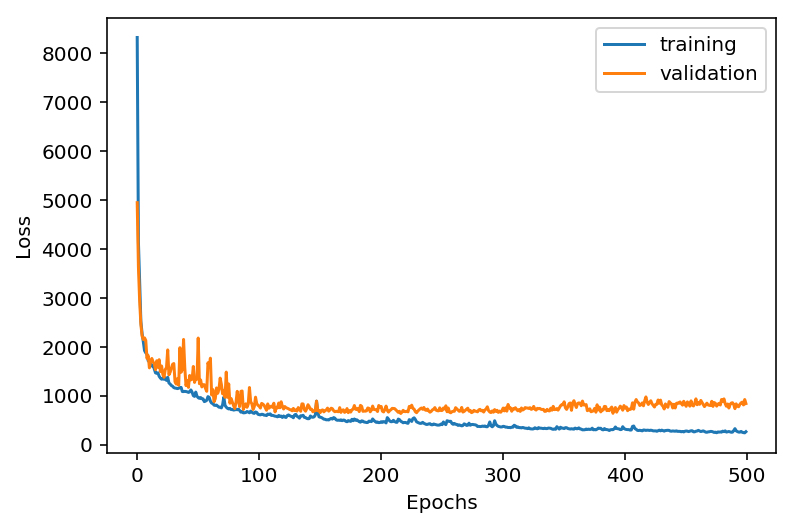

In [6]:
#print(history.model.history.history)
plt.plot(vae.history.epoch, vae.history.history['loss'], label="training")
plt.plot(vae.history.epoch, vae.history.history['val_loss'], label="validation")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
#plt.ylim((0, 500000))
plt.savefig(os.path.join(_figPath, f"loss_{_latent_dim}_{_loss}"))

In [7]:
if _latent_dim == 2:
    plot_results(models, (x_test, y_test), batch_size=_batch_size, model_name=f"vae_{_latent_dim}_{_loss}_test")

In [8]:
if _latent_dim == 2:
    plot_results(models, (x_train, y_train), batch_size=_batch_size, model_name=f"vae_{_latent_dim}_{_loss}_train")

[ 57  34  33  95 159]
range(0, 5)
[[ 1.31580091 -2.12920666 -1.16186285  0.01230448 -4.19386816  0.25023243
  -0.09910078 -0.12333068 -0.77014232 -0.84998655]]
[[-1.46983516 -0.58379805  0.04747311  0.92060167  1.8514154  -0.15580574
   1.04880834 -0.13881165  0.21951485  1.33747411]]
[[-1.34542096 -0.66101122  0.42530087  0.66668212  0.6536392   0.02394885
   1.41147959  0.75097287  0.14510342  1.33565366]]
[[-1.84070408 -1.77499115 -1.18831348  2.06908965 -1.71058714 -0.39891374
   0.05308799 -1.11833906 -0.58342719 -0.18441719]]
[[ 0.93134981 -0.83826303 -0.30461976  3.91349864  1.11736941 -0.05517231
  -2.73821473  0.66722488  0.0666962   0.68847924]]


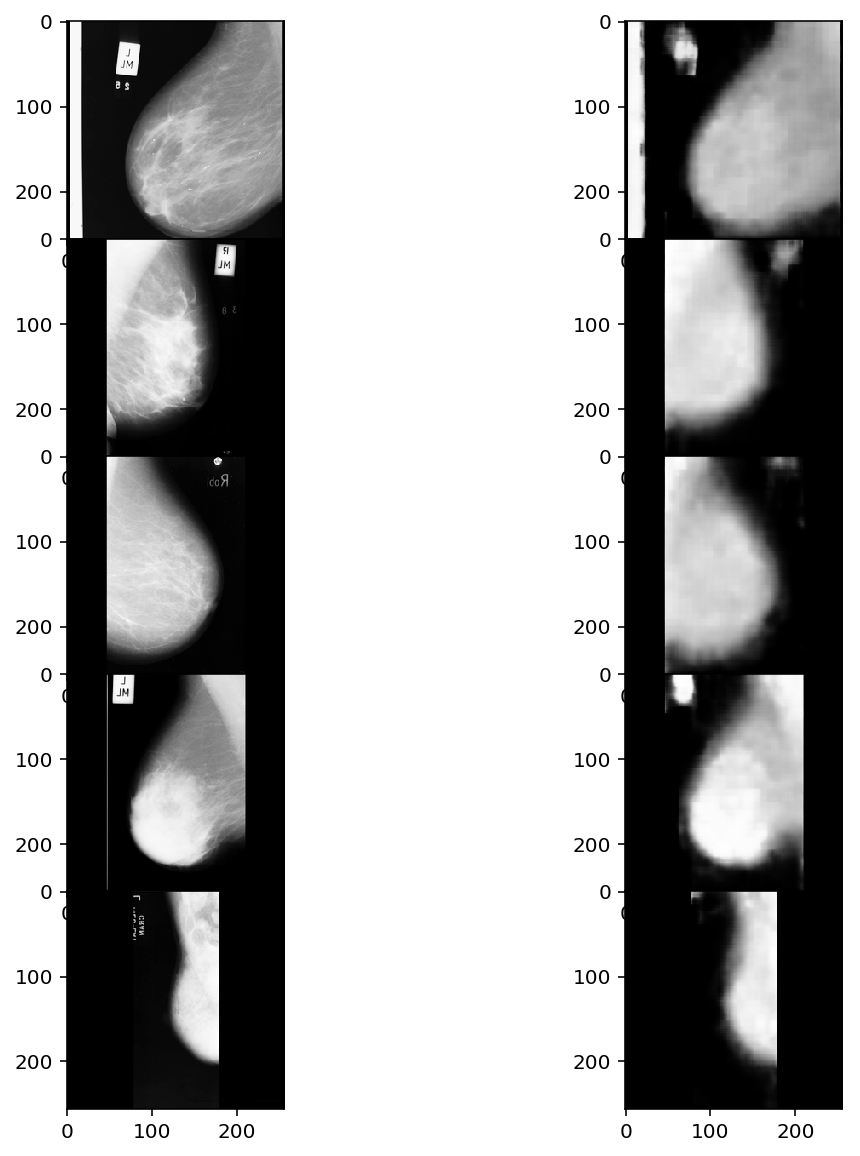

In [9]:
idxs = np.random.randint(1,322*0.8, 5)
print(idxs)
print(range(len(idxs)))
fig, axs = plt.subplots(nrows = 5, ncols=2, figsize=(10, 10))
axs = axs.ravel()
fig.subplots_adjust(hspace = .001, wspace=.001)

i = 0
idx = 0
while i < 10:
    test_img = x_train[idxs[idx]]
    axs[i].imshow(test_img[:,:,0], cmap='Greys_r')
    z_test = encoder.predict(np.array([test_img]))[0] 
    print(z_test)
    test_pred  = decoder.predict(z_test)[0]
    axs[i+1].imshow(test_pred[:,:,0], cmap='Greys_r')
    i = i + 2
    idx = idx + 1    

fig.savefig(os.path.join(_figPath, f'result_{_latent_dim}_{_loss}.png'))

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]
0.215699881315
(array([20, 54]), array([54, 20]))
1
20


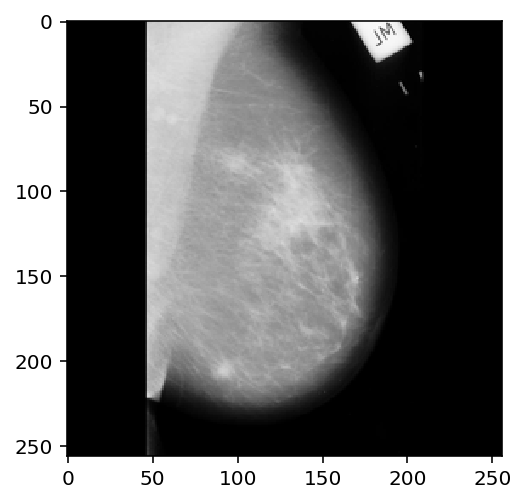

(1, 10)
[[-1.24646366 -0.27356577  0.39893678  0.72983819  0.90249813 -0.04058889
   0.99803609  0.44557124  0.25561514  1.06684339]]


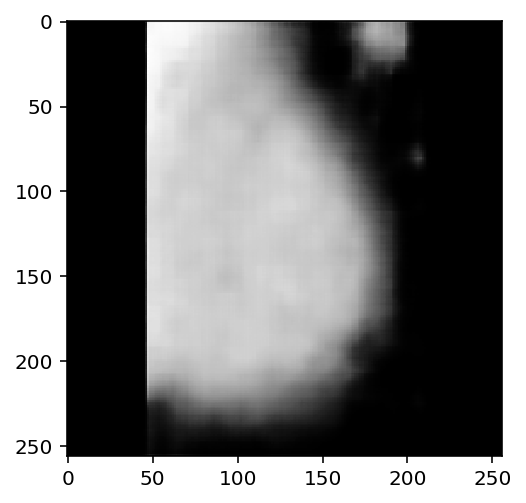

0
54


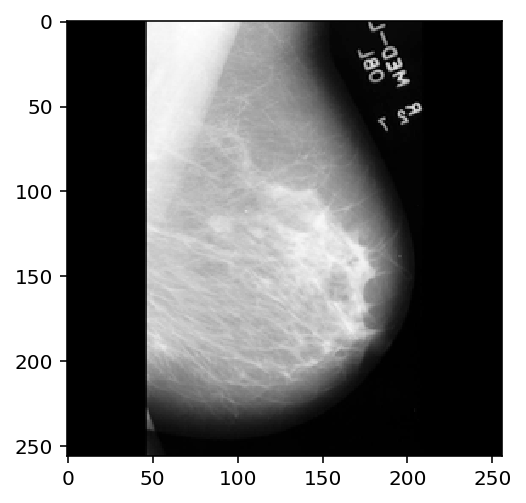

(1, 10)
[[-1.35628164 -0.06771451  0.46784976  0.69977885  0.88539678 -0.06523874
   0.96892172  0.40300107  0.30721694  0.96130288]]


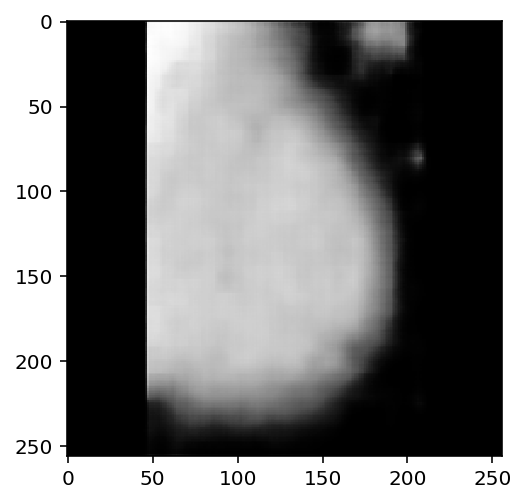

In [10]:
z_train = encoder.predict(x_train)[0]
z_train_0 = z_train[y_train]
z_train_1 = z_train[y_train]
np.linalg.norm(z_train[0] - z_train[1])
R = np.zeros((len(z_train), len(z_train)))
for i in range(len(z_train)):
    for j in range(len(z_train)):
        if i == j:
            R[i,j] = None
        elif y_train[i] == y_train[j]:
            R[i,j] = None
        else:
            R[i,j] = np.linalg.norm(z_train[i] - z_train[j])
print(R)
print(np.nanmin(R))
result = np.where(R == np.nanmin(R))
smallest1 = np.nanmin(R)
smallest2 = np.nanmin(np.array(R)[R != smallest1])
result = np.where(R == smallest2)
print(result)
print(y_train[result[0][0]])
print(result[0][0])
image_1 = x_train[result[0][0]]
plt.imshow(image_1[:,:,0],cmap='Greys_r')
plt.savefig(os.path.join(_figPath, f'X_1_{_latent_dim}_{_loss}.png'), bbox_inches='tight')
plt.show()
z_1 = encoder.predict(np.array([image_1]))[0]

print(z_1.shape)
print(z_1)
pred_1 = decoder.predict(z_1)
plt.imshow(pred_1[0][:,:,0], cmap='Greys_r')
plt.savefig(os.path.join(_figPath, f'pred_2_{_latent_dim}_{_loss}.png'), bbox_inches='tight')
plt.show()


print(y_train[result[0][1]])
print(result[0][1])
image_2 = x_train[result[0][1]]
plt.imshow(image_2[:,:,0],cmap='Greys_r')
plt.savefig(os.path.join(_figPath, f'X_2_{_latent_dim}_{_loss}.png'), bbox_inches='tight')
plt.show()
z_2 = encoder.predict(np.array([image_2]))[0]

print(z_2.shape)
print(z_2)
pred_2 = decoder.predict(z_2)
plt.imshow(pred_2[0][:,:,0], cmap='Greys_r')
plt.savefig(os.path.join(_figPath, f'pred_2_{_latent_dim}_{_loss}.png'), bbox_inches='tight')
plt.show()

[ 0.    0.25  0.5   0.75  1.  ]


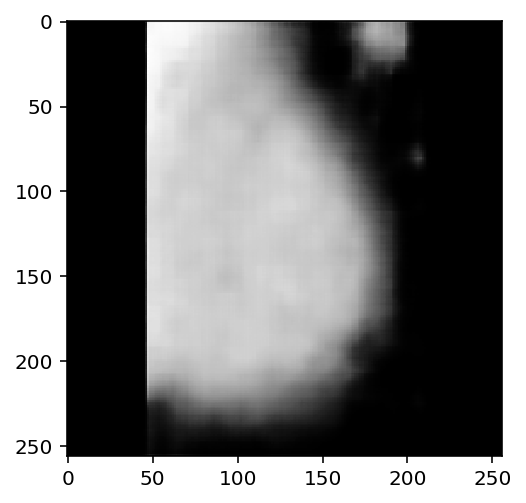

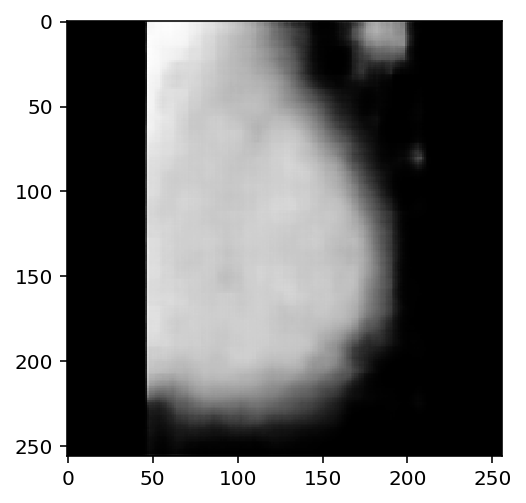

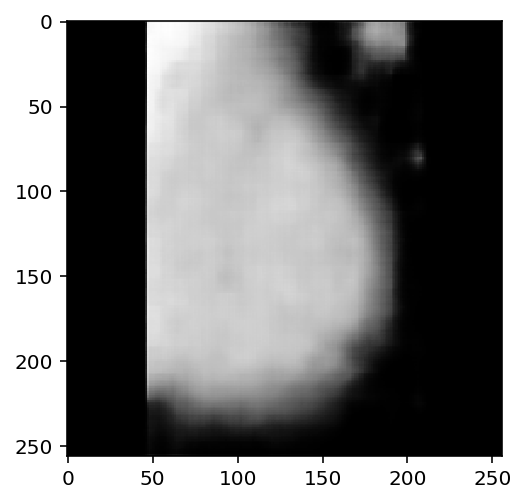

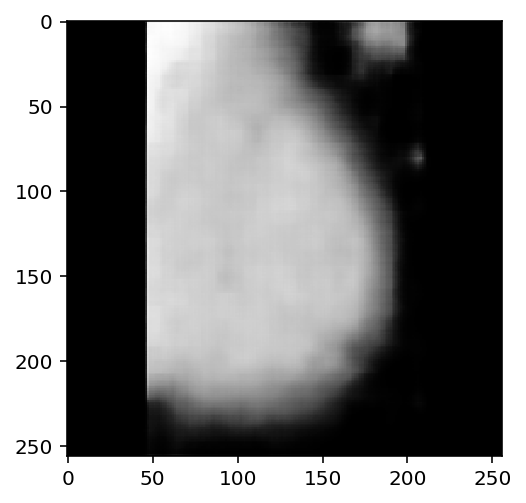

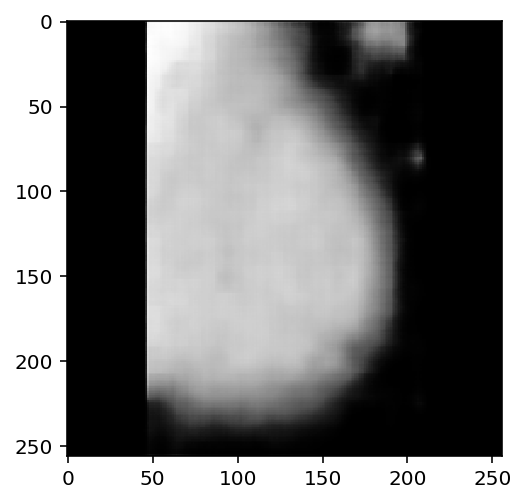

In [11]:
t = np.linspace(0,1,5)
print(t)

for i in t:
    z = (1-i)*z_1 + i*z_2
    test = decoder.predict(z)
    plt.imshow(test[0][:,:,0], cmap='Greys_r')
    plt.savefig(os.path.join(_figPath, f'{int(i*100)}_{_latent_dim}_{_loss}.png'), bbox_inches='tight')
    plt.show()